# Import packages

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Import the FBM sinusoidal endo

In [3]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20201007.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 103228 × 33712 
    obs: 'cell.labels', 'doublets', 'fetal.ids', 'gender', 'is_doublet', 'is_doublet_poptrim', 'is_doublet_wolock', 'lanes', 'nGene', 'nUMI', 'orig.ident', 'percent.mito', 'processing.type', 'scrublet_cluster_score', 'scrublet_score', 'sequencing.type', 'sort.ids', 'april_cell.labels', 'cell.labels_20200708', 'cell.labels_20200713', 'cell.labels_20200718', 'nk_meta', 'mito.threshold'
    var: 'gene_ids-1', 'feature_types-1'
    obsm: 'X_orig_pca', 'X_pca', 'X_umap'

In [5]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell             327
CD8 T cell             171
CD14 monocyte         8763
CD56 bright NK         449
CMP                    425
                      ... 
schwann cells            9
sinusoidal EC          550
stromal macrophage    1464
tDC                    193
tip EC                 362
Length: 64, dtype: int64

In [6]:
from scipy import sparse
array_vals = adata.X
adata.X = sparse.csr_matrix(adata.X)
adata.raw = adata
adata.X = array_vals

In [7]:
adata = adata[adata.obs['cell.labels'].isin(['sinusoidal EC'])].copy()

In [8]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
sinusoidal EC    550
dtype: int64

In [9]:
adata.obs["dataset"] = "FBM"

In [10]:
fbm = adata

# Import the FL sinusoidal EC

In [11]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/liver/data/fetal_liver_alladata_Copy1.h5ad')

In [12]:
adata

AnnData object with n_obs × n_vars = 113063 × 27080 
    obs: 'nGene', 'nUMI', 'orig.ident', 'percent.mito', 'fetal.ids', 'sort.ids', 'tissue', 'lanes', 'stages', 'sample.type', 'gender', 'AnnatomicalPart', 'doublets', 'cell.labels', 'combined.labels', 'batch', 'sample', 'n_counts', 'cell.labels_progen'
    obsm: 'X_fdg', 'X_tsne', 'X_umap'

In [13]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
B cell                            1079
DC1                                336
DC2                               3954
DC precursor                       330
Early Erythroid                  11985
Early lymphoid_T lymphocyte        767
Endothelial cell                  3348
Fibroblast                        1713
HSC_MPP                           3439
Hepatocyte                        2479
ILC precursor                     1726
Kupffer Cell                     24841
Late Erythroid                    3180
MEMP                              1342
Mast cell                         1308
Megakaryocyte                     3983
Mid Erythroid                    27000
Mono-Mac                          6590
Monocyte                          2586
Monocyte precursor                 350
NK                                6706
Neutrophil-myeloid progenitor      658
Pre pro B cell                     234
VCAM1+ EI macrophage               161
pDC precursor                      253
pre-B cell   

In [14]:
adata = adata[adata.obs['cell.labels'].isin(['Endothelial cell'])].copy()

In [15]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
Endothelial cell    3348
dtype: int64

In [16]:
annot = pd.read_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/resources_for_pipelines/fl_endo_meta.csv", index_col=0)
adata.obs["sinu_annot"] = annot

In [17]:
cell_numbers = adata.obs.groupby(["sinu_annot"]).apply(len)
cell_numbers

sinu_annot
MK-endo hybrid (physiological)      20
artery                             173
heptatocyte                         68
macrophage                         234
proliferating EC                   617
sinusoidal EC                     1715
tip EC                             209
vascular fibroblast                312
dtype: int64

In [18]:
adata = adata[adata.obs['sinu_annot'].isin(['sinusoidal EC'])].copy()

In [19]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
Endothelial cell    1715
dtype: int64

In [20]:
adata.obs["old_cell.labels"] = adata.obs["cell.labels"]
adata.obs["cell.labels"] = adata.obs['sinu_annot']

In [21]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
sinusoidal EC    1715
dtype: int64

In [22]:
adata.obs["dataset"] = "liver"
liver = adata

# Combine the datasets

In [23]:
liver.X = liver.X.toarray()

In [24]:
from scipy import sparse

objects = [liver, fbm]

for i in objects:
    array_vals = i.X
    i.X = sparse.csr_matrix(i.X)
    i.raw = i
    i.X = array_vals

In [25]:
merged = liver.concatenate(fbm, index_unique=None, join='inner')

In [26]:
merged.shape

(2265, 27079)

In [27]:
cell_numbers = merged.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
sinusoidal EC    2265
dtype: int64

In [28]:
merged.obs["dataset_cell.labels"] = merged.obs["dataset"].astype(str) + '_' + merged.obs["cell.labels"].astype(str)

In [29]:
cell_numbers = merged.obs.groupby(["dataset_cell.labels"]).apply(len)
cell_numbers

dataset_cell.labels
FBM_sinusoidal EC       550
liver_sinusoidal EC    1715
dtype: int64

# Pre-process the data

In [30]:
adata=merged

In [31]:
# normalise count data 
sc.pp.normalize_total(adata)

In [32]:
# log the count data 
sc.pp.log1p(adata)

In [33]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [34]:
# scale the data 
sc.pp.scale(adata, max_value=10)
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

# Run the dotplot / violin plot

In [35]:
genes = pd.read_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/resources_for_pipelines/sinusoidal_gene_heatmap.csv")
genes = genes["genes"].tolist()

... storing 'AnnatomicalPart' as categorical
... storing 'april_cell.labels' as categorical
... storing 'cell.labels' as categorical
... storing 'cell.labels_20200708' as categorical
... storing 'cell.labels_20200713' as categorical
... storing 'cell.labels_20200718' as categorical
... storing 'cell.labels_progen' as categorical
... storing 'combined.labels' as categorical
... storing 'dataset' as categorical
... storing 'doublets' as categorical
... storing 'fetal.ids' as categorical
... storing 'gender' as categorical
... storing 'is_doublet' as categorical
... storing 'is_doublet_poptrim' as categorical
... storing 'is_doublet_wolock' as categorical
... storing 'lanes' as categorical
... storing 'mito.threshold' as categorical
... storing 'nk_meta' as categorical
... storing 'old_cell.labels' as categorical
... storing 'orig.ident' as categorical
... storing 'processing.type' as categorical
... storing 'sample' as categorical
... storing 'sample.type' as categorical
... storing 'seq

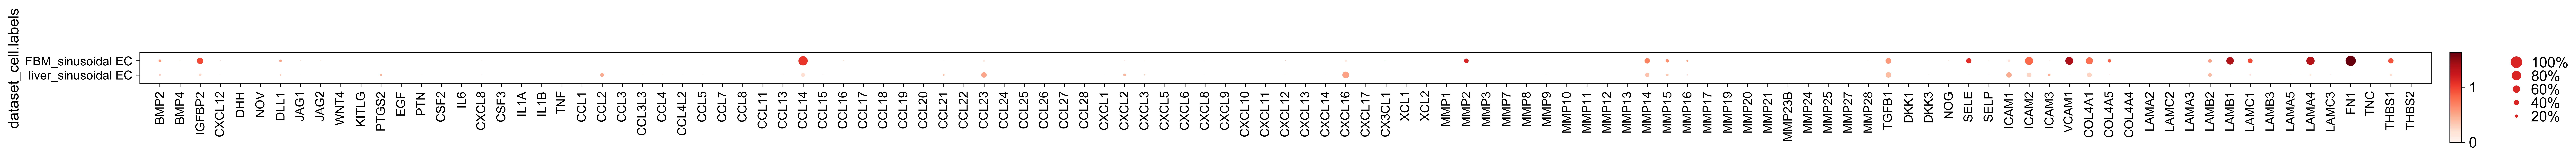

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[39.55, 0, 0.2, 0.5, 0.25])

In [36]:
sc.settings.set_figure_params(dpi=300, dpi_save=1000)
sc.pl.dotplot(adata, var_names=genes, groupby="dataset_cell.labels", use_raw=False, 
              save="fig6b_sinusoidal_EC_fl_fbm_dotplot_20210126.pdf")

In [37]:
sinusoidal_lit_genes=[
# adhesion
'SELE',
'ICAM1',
'ICAM2',
'ICAM3',
'VCAM1',
# extracellular matrix
'COL4A1',
'LAMB1',
'FN1',
'THBS1',
'MMP2',
'MMP14',
'MMP15',
# angiopoietins
'BMP2',
'BMP4',
'IGFBP2',
'DLL1',
'CXCL12',
'KITLG',
'CCL14',
'CCL23',
'TGFB1']

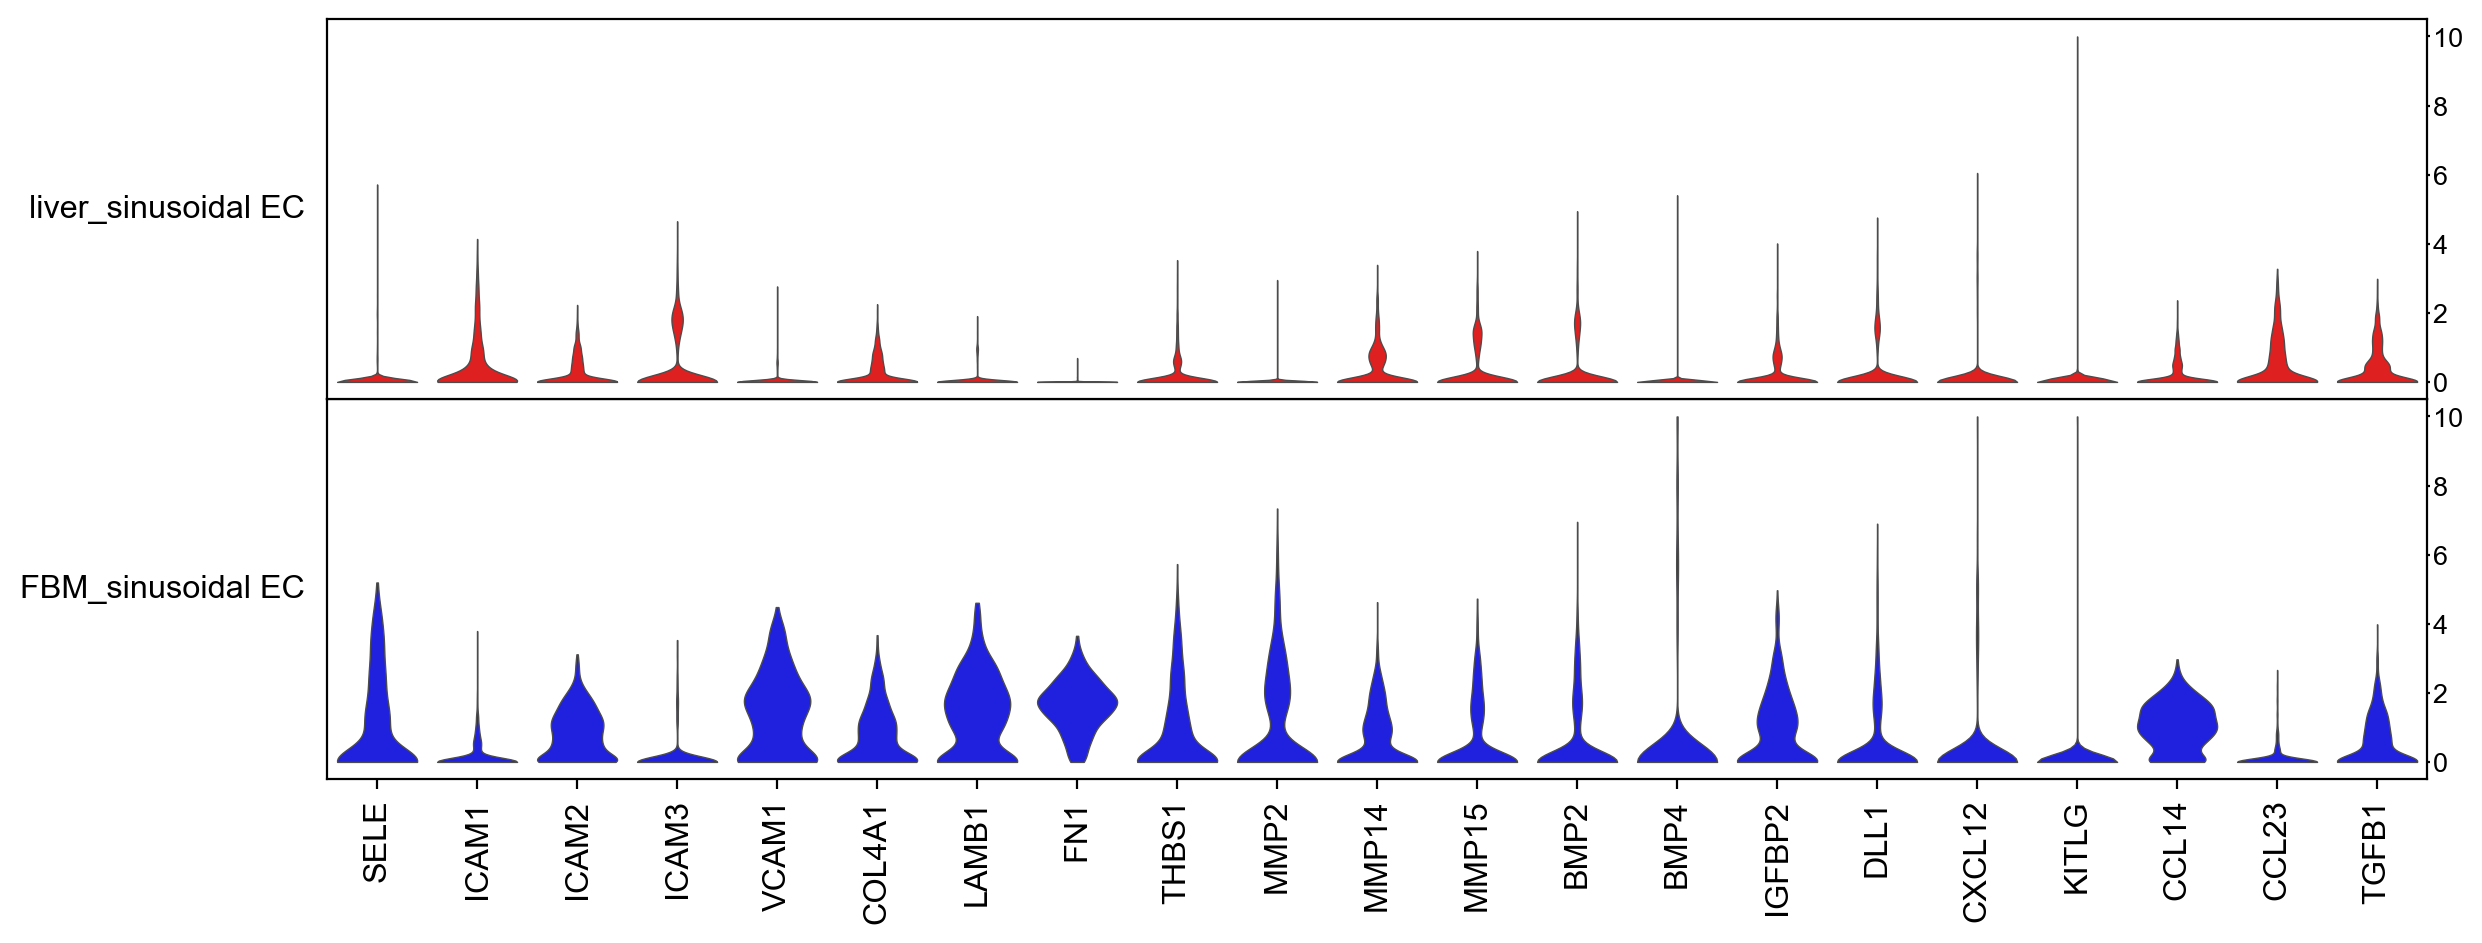

In [38]:
sc.settings.set_figure_params(dpi=100, dpi_save=1000)

adata.obs["dataset_cell.labels"] = adata.obs["dataset_cell.labels"].cat.reorder_categories(
    ['liver_sinusoidal EC', 'FBM_sinusoidal EC'])

sc.pl.stacked_violin(adata, var_names=sinusoidal_lit_genes, save="sinusoidal_endo_fl_fbm_violin_20210126.pdf", 
                     rotation=90, 
                     groupby='dataset_cell.labels', use_raw=False, swap_axes=False, figsize=(14,5), 
                     row_palette=["#ff0000", "#0000ff"])

# Run some stats now

In [39]:
subset = adata[:, sinusoidal_lit_genes].copy()

sc.tl.rank_genes_groups(subset, groupby='dataset_cell.labels', method='wilcoxon', use_raw=False, 
                        log_transformed=True, groups=['liver_sinusoidal EC', 'FBM_sinusoidal EC'], n_genes=subset.shape[1])

# save df for filtered degs
result = subset.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs_by_cluster = pd.DataFrame({group + '_' + key[:7]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'pvals', 'pvals_adj']})
# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/figs/clustering_degs/fig6b_fbm_fl_sinusoidal_violin_degs_20210126.csv")
degs_by_cluster

,liver_sinusoidal EC_names,liver_sinusoidal EC_logfold,liver_sinusoidal EC_pvals,liver_sinusoidal EC_pvals_a,FBM_sinusoidal EC_names,FBM_sinusoidal EC_logfold,FBM_sinusoidal EC_pvals,FBM_sinusoidal EC_pvals_a
0,CCL23,2.472404,1.569840e-38,3.662959e-38,FN1,9.218721,1.104689e-260,2.319847e-259
1,ICAM1,1.664687,3.550058e-20,6.212601e-20,VCAM1,5.995254,6.222931e-143,6.534077e-142
2,ICAM3,1.830873,5.152266e-09,7.728399e-09,CCL14,2.967206,7.144222e-139,5.000955e-138
3,KITLG,-1.475163,8.615247e-01,8.615247e-01,LAMB1,5.509399,7.844029e-127,4.118115e-126
4,CXCL12,-1.497048,1.578093e-01,1.656998e-01,ICAM2,2.033673,3.930702e-63,1.650895e-62
5,BMP4,-5.937834,7.268676e-03,8.033800e-03,SELE,4.683246,2.517192e-59,8.810173e-59
6,DLL1,-1.052994,2.363129e-03,2.756984e-03,MMP2,7.440580,2.581181e-52,7.743544e-52
7,BMP2,-1.153437,2.718949e-04,3.358701e-04,IGFBP2,2.516279,3.159951e-48,8.294872e-48
8,TGFB1,-0.632339,2.602266e-04,3.358701e-04,COL4A1,1.952300,2.006425e-37,4.213493e-37
9,MMP15,-1.111913,5.278139e-05,7.389394e-05,THBS1,2.655996,1.211412e-32,2.312695e-32


# Save data

In [40]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [41]:
adata.X

<2265x27079 sparse matrix of type '<class 'numpy.float32'>'
	with 5344254 stored elements in Compressed Sparse Row format>

In [42]:
adata.raw.X

<2265x27079 sparse matrix of type '<class 'numpy.float32'>'
	with 6026120 stored elements in Compressed Sparse Row format>

In [43]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/data/fig6b_fbm_fl_sinusoidal_endo_20210126.h5ad")